# Version 0.1: Dense MoE

1. `MoE` loop each `Expert`.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate synthetic dataset
n_features = 7070
n_classes = 5
X, y = make_classification(n_samples=69, n_features=n_features, 
                           n_informative=10, n_classes=n_classes, 
                           weights=[39/69, 7/69, 7/69, 10/69, 6/69], random_state=42)

# Step 2: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                  stratify=y, random_state=42)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# Define the Expert Network
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
      super().__init__()
      self.fc1 = nn.Linear(input_dim, 50)
      self.fc2 = nn.Linear(50, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = torch.relu(self.fc1(x))
      return self.fc2(x)

# Define the Gating Network
class Router(nn.Module):
    def __init__(self, input_dim, num_experts):
      super().__init__()
      self.fc = nn.Linear(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, num_experts]
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.fc(x) # Softmax to get probabilities for each expert

# Define the MoE Model
class MoE(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, num_experts: int):
      super().__init__()
      self.num_experts = num_experts
      
      # Create the experts
      self.experts = nn.ModuleList([Expert(input_dim, output_dim) for _ in range(num_experts)])

      # Create the router
      self.router = Router(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, output_dim]
    # Note: The gradients are computed 
    # based on how much each expert's output contribution to the loss.
    # If the an expert is used only once for a specific sample,
    # it will receive a gradient based only on that single sample's contribution
    # to the overall loss.
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      # Get the output from topk experts
      expert_outputs = torch.stack([self.experts[i](x) for i in range(self.num_experts)], dim=0) # [num_experts, batch_size, output_dim]

      # Get router logts
      router_logits: torch.Tensor = self.router(x) # [batch_size, num_experts]

      # Weighted sum of expert outputs
      weighted_outputs = expert_outputs * router_logits.permute(1,0).unsqueeze(-1)

      return weighted_outputs.sum(dim=0)

# Training the MoE model
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, 
               optimizer: torch.optim.Optimizer):
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    # Compute predictions and loss
    pred = model(X)
    loss: torch.Tensor = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  loss, current = loss.item(), batch * batch_size + len(X)
  print(f"loss: {loss:>7f} [{current:>2d}/{size:>2d}]")

# Evaluate the MoE model
def test_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred: torch.Tensor = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).sum().item()
  
  correct /= size
  test_loss /= num_batches
  print(f'Test Error: \n Accuracy: {100 * correct:>0.1f}%, Avg loss: {test_loss:>8f} \n')

# Instantiate the MoE model
model = MoE(input_dim=n_features, output_dim=n_classes, num_experts=4)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_loader, model, loss_fn, optimizer) # Train the model
  test_loop(val_loader, model, loss_fn) # Evaluate the model on the validation set

Epoch 1
-------------------------------
loss: 1.877403 [48/48]
Test Error: 
 Accuracy: 28.6%, Avg loss: 1.655473 



# Version 0.2: Naive Sparse MoE

1. `MoE` loop each `Expert`.
2. `Expert` receive `x` with dimensions `[batch_size, input_dim]`.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate synthetic dataset
n_features = 7070
n_classes = 5
X, y = make_classification(n_samples=69, n_features=n_features, 
                           n_informative=10, n_classes=n_classes, 
                           weights=[39/69, 7/69, 7/69, 10/69, 6/69], random_state=42)

# Step 2: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                  stratify=y, random_state=42)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# Define the Expert Network
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
      super().__init__()
      self.fc1 = nn.Linear(input_dim, 50)
      self.fc2 = nn.Linear(50, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = torch.relu(self.fc1(x))
      return self.fc2(x)

# Define the Gating Network
class Router(nn.Module):
    def __init__(self, input_dim, num_experts):
      super().__init__()
      self.fc = nn.Linear(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, num_experts]
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.fc(x) # Softmax to get probabilities for each expert

# Define the MoE Model
class MoE(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, num_experts: int, top_k: int):
      super().__init__()
      self.num_experts = num_experts
      self.top_k = top_k
      
      # Create the experts
      self.experts = nn.ModuleList([Expert(input_dim, output_dim) for _ in range(num_experts)])

      # Create the router
      self.router = Router(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, output_dim]
    # Note: The gradients are computed 
    # based on how much each expert's output contribution to the loss.
    # If the an expert is used only once for a specific sample,
    # it will receive a gradient based only on that single sample's contribution
    # to the overall loss.
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      # Get the output from topk experts
      expert_outputs = torch.stack([self.experts[i](x) for i in range(self.num_experts)], dim=0) # [num_experts, batch_size, output_dim]

      # Get router logts
      router_logits: torch.Tensor = self.router(x) # [batch_size, num_experts]
      # Get the top-k expert indices for each sample in the batch
      topk_values, topk_indices = torch.topk(router_logits, self.top_k, dim=-1) # [batch_size, top_k]
      # Select the outputs of the top-k experts
      selected_expert_outputs = torch.gather(expert_outputs, 0, topk_indices.unsqueeze(2).expand(-1, -1, expert_outputs.size(-1)))

      # Weighted sum of expert outputs
      weighted_outputs = selected_expert_outputs * topk_values.unsqueeze(-1)

      return weighted_outputs.sum(dim=1)

# Training the MoE model
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, 
               optimizer: torch.optim.Optimizer):
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    # Compute predictions and loss
    pred = model(X)
    loss: torch.Tensor = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  loss, current = loss.item(), batch * batch_size + len(X)
  print(f"loss: {loss:>7f} [{current:>2d}/{size:>2d}]")

# Evaluate the MoE model
def test_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred: torch.Tensor = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).sum().item()
  
  correct /= size
  test_loss /= num_batches
  print(f'Test Error: \n Accuracy: {100 * correct:>0.1f}%, Avg loss: {test_loss:>8f} \n')

# Instantiate the MoE model
model = MoE(input_dim=n_features, output_dim=n_classes, num_experts=4, top_k=2)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_loader, model, loss_fn, optimizer) # Train the model
  test_loop(val_loader, model, loss_fn) # Evaluate the model on the validation set

Epoch 1
-------------------------------
loss: 1.983201 [48/48]
Test Error: 
 Accuracy: 14.3%, Avg loss: 1.732244 



# Version 0.3: Sparse MoE

1. `MoE` loop each `Expert`.
2. `Expert` receives `expert_input`

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate synthetic dataset
n_features = 7070
n_classes = 5
X, y = make_classification(n_samples=69, n_features=n_features, 
                           n_informative=10, n_classes=n_classes, 
                           weights=[39/69, 7/69, 7/69, 10/69, 6/69], random_state=42)

# Step 2: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                  stratify=y, random_state=42)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# Define the Expert Network
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
      super().__init__()
      self.fc1 = nn.Linear(input_dim, 50)
      self.fc2 = nn.Linear(50, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = torch.relu(self.fc1(x))
      return self.fc2(x)

# Define the Gating Network
class Router(nn.Module):
    def __init__(self, input_dim, num_experts):
      super().__init__()
      self.fc = nn.Linear(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, num_experts]
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.fc(x) # Softmax to get probabilities for each expert

# Define the MoE Model
class MoE(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, num_experts: int, top_k: int):
      super().__init__()
      self.output_dim = output_dim
      self.num_experts = num_experts
      self.top_k = top_k
      
      # Create the experts
      self.experts = nn.ModuleList([Expert(input_dim, output_dim) for _ in range(num_experts)])

      # Create the router
      self.router = Router(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, output_dim]
    # Note: The gradients are computed 
    # based on how much each expert's output contribution to the loss.
    # If the an expert is used only once for a specific sample,
    # it will receive a gradient based only on that single sample's contribution
    # to the overall loss.
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      # Get router logts
      router_logits: torch.Tensor = self.router(x) # [batch_size, num_experts]

      # Get the top-k expert indices for each sample in the batch
      topk_logits, topk_indices = torch.topk(router_logits, self.top_k, dim=-1) # [batch_size, top_k]

      weighted_outputs = torch.zeros(x.size(0), self.output_dim)
      for i, expert in enumerate(self.experts):
        expert_mask = (topk_indices == i).any(dim=-1) # [top_k]

        if expert_mask.any():
          expert_input = x[expert_mask]
          expert_output = expert(expert_input)

          expert_logits = topk_logits[topk_indices == i]
          weighted_output = expert_output * expert_logits.unsqueeze(-1)

          weighted_outputs[expert_mask] += weighted_output

      return weighted_outputs

# Training the MoE model
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, 
               optimizer: torch.optim.Optimizer):
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    # Compute predictions and loss
    pred = model(X)
    loss: torch.Tensor = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  loss, current = loss.item(), batch * batch_size + len(X)
  print(f"loss: {loss:>7f} [{current:>2d}/{size:>2d}]")

# Evaluate the MoE model
def test_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred: torch.Tensor = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).sum().item()
  
  correct /= size
  test_loss /= num_batches
  print(f'Test Error: \n Accuracy: {100 * correct:>0.1f}%, Avg loss: {test_loss:>8f} \n')

# Instantiate the MoE model
model = MoE(input_dim=n_features, output_dim=n_classes, num_experts=4, top_k=2)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_loader, model, loss_fn, optimizer) # Train the model
  test_loop(val_loader, model, loss_fn) # Evaluate the model on the validation set

Epoch 1
-------------------------------
loss: 2.827578 [48/48]
Test Error: 
 Accuracy: 9.5%, Avg loss: 1.673539 



# Version 0.4: Sparse MoE with Noise

1. `MoE` loop each `Expert`.
2. `Expert` receives `expert_input`.
3. `Router` add noise to `x`.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate synthetic dataset
n_features = 7070
n_classes = 5
X, y = make_classification(n_samples=69, n_features=n_features, 
                           n_informative=10, n_classes=n_classes, 
                           weights=[39/69, 7/69, 7/69, 10/69, 6/69], random_state=42)

# Step 2: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                  stratify=y, random_state=42)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# Define the Expert Network
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
      super().__init__()
      self.fc1 = nn.Linear(input_dim, 5)
      self.fc2 = nn.Linear(5, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = torch.relu(self.fc1(x))
      return self.fc2(x)

# Define the Gating Network
class Router(nn.Module):
    def __init__(self, input_dim, num_experts):
      super().__init__()
      self.fc = nn.Linear(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, num_experts]
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.fc(x)
      if self.training:
        x += torch.randn_like(x) # Add noise to the logits
      return x

# Define the MoE Model
class MoE(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, num_experts: int, top_k: int):
      super().__init__()
      self.output_dim = output_dim
      self.num_experts = num_experts
      self.top_k = top_k
      
      # Create the experts
      self.experts = nn.ModuleList([Expert(input_dim, output_dim) for _ in range(num_experts)])

      # Create the router
      self.router = Router(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, output_dim]
    # Note: The gradients are computed 
    # based on how much each expert's output contribution to the loss.
    # If the an expert is used only once for a specific sample,
    # it will receive a gradient based only on that single sample's contribution
    # to the overall loss.
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      # Get router logts
      router_logits: torch.Tensor = self.router(x) # [batch_size, num_experts]

      # Get the top-k expert indices for each sample in the batch
      topk_logits, topk_indices = torch.topk(router_logits, self.top_k, dim=-1) # [batch_size, top_k]

      weighted_outputs = torch.zeros(x.size(0), self.output_dim)
      for i, expert in enumerate(self.experts):
        expert_mask = (topk_indices == i).any(dim=-1) # [top_k]

        if expert_mask.any():
          expert_input = x[expert_mask]
          expert_output = expert(expert_input)

          expert_logits = topk_logits[topk_indices == i]
          weighted_output = expert_output * expert_logits.unsqueeze(-1)

          weighted_outputs[expert_mask] += weighted_output

      return weighted_outputs

# Training the MoE model
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, 
               optimizer: torch.optim.Optimizer):
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    # Compute predictions and loss
    pred = model(X)
    loss: torch.Tensor = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  loss, current = loss.item(), batch * batch_size + len(X)
  print(f"loss: {loss:>7f} [{current:>2d}/{size:>2d}]")

# Evaluate the MoE model
def test_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).sum().item()
  
  correct /= size
  test_loss /= num_batches
  print(f'Test Error: \n Accuracy: {100 * correct:>0.1f}%, Avg loss: {test_loss:>8f} \n')

# Instantiate the MoE model
model = MoE(input_dim=n_features, output_dim=n_classes, num_experts=4, top_k=2)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_loader, model, loss_fn, optimizer) # Train the model
  test_loop(val_loader, model, loss_fn) # Evaluate the model on the validation set

Epoch 1
-------------------------------
loss: 3.051296 [48/48]
Test Error: 
 Accuracy: 28.6%, Avg loss: 1.715019 

Epoch 2
-------------------------------
loss: 4.368128 [48/48]
Test Error: 
 Accuracy: 14.3%, Avg loss: 1.762916 

Epoch 3
-------------------------------
loss: 2.000396 [48/48]
Test Error: 
 Accuracy: 9.5%, Avg loss: 1.712291 

Epoch 4
-------------------------------
loss: 3.174237 [48/48]
Test Error: 
 Accuracy: 14.3%, Avg loss: 1.718284 

Epoch 5
-------------------------------
loss: 6.014785 [48/48]
Test Error: 
 Accuracy: 19.0%, Avg loss: 1.758571 

Epoch 6
-------------------------------
loss: 0.928673 [48/48]
Test Error: 
 Accuracy: 23.8%, Avg loss: 1.751489 

Epoch 7
-------------------------------
loss: 0.067877 [48/48]
Test Error: 
 Accuracy: 19.0%, Avg loss: 1.744448 

Epoch 8
-------------------------------
loss: 0.051381 [48/48]
Test Error: 
 Accuracy: 19.0%, Avg loss: 1.722980 

Epoch 9
-------------------------------
loss: 0.715868 [48/48]
Test Error: 
 Accu

# Version 0.5: Expert Capacity "Prevent Overtrained Expert Train"

1. `MoE` loop each `Expert`.
2. If the `expert_capacity` is exceeded, then the `sample`(s) are removed from the `mini-batch`.
3. `Expert` receives `expert_input`.
4. `Router` add noise to `x`.

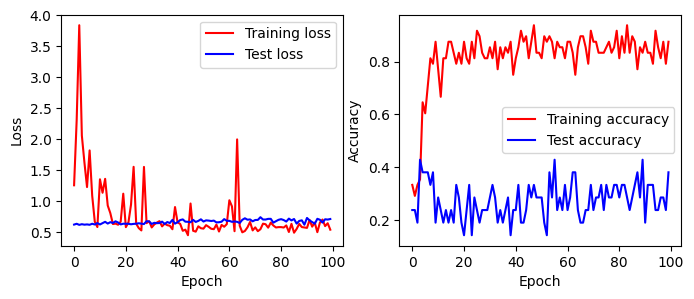

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Generate synthetic dataset
n_features = 7070
n_classes = 5
X, y = make_classification(n_samples=69, n_features=n_features, 
                           n_informative=10, n_classes=n_classes, 
                           weights=[39/69, 7/69, 7/69, 10/69, 6/69], random_state=42)

# Step 2: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    stratify=y, random_state=42)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# Define the Expert Network
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
      super().__init__()
      self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return torch.relu(self.fc(x))

# Define the Gating Network
class Router(nn.Module):
    def __init__(self, input_dim, num_experts):
      super().__init__()
      self.fc = nn.Linear(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, num_experts]
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.fc(x)
      if self.training:
        x += torch.randn_like(x) # Add noise to the logits
      return x
    
def topk(router_logits: torch.Tensor, top_k: int, dim: int, expert_capacity: int) -> tuple[torch.Tensor, torch.Tensor]:
  batch_size = router_logits.size(0)
  num_experts = router_logits.size(1)
  topk_logits, topk_indices = torch.topk(router_logits, top_k, dim=dim) # [batch_size, top_k]
  
  sorted_indices = torch.argsort(router_logits, dim=dim, descending=True)
  new_logits, new_indices = topk_logits.clone(), topk_indices.clone()

  expert_assigned = torch.zeros(num_experts)
  for i in range(batch_size):
    if (expert_assigned == expert_capacity).sum() == 4:
      break

    for j in range(top_k):
      expert_index = sorted_indices[i, j]
      if expert_assigned[expert_index] < expert_capacity:
        expert_assigned[expert_index] += 1
        continue

      for next_expert_index in sorted_indices[i, j:]:
        if expert_assigned[next_expert_index] == expert_capacity:
          continue

        if next_expert_index in new_indices[i]: # prevent duplicate
          continue

        new_logits[i, j] = router_logits[i, next_expert_index]
        new_indices[i, j] = next_expert_index
        expert_assigned[next_expert_index] += 1
        break

  return new_logits, new_indices

# Define the MoE Model
class MoE(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, num_experts: int, top_k: int):
      super().__init__()
      self.output_dim = output_dim
      self.num_experts = num_experts
      self.top_k = top_k
      
      # Create the experts
      self.experts = nn.ModuleList([Expert(input_dim, output_dim) for _ in range(num_experts)])

      # Create the router
      self.router = Router(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, output_dim]
    # Note: The gradients are computed 
    # based on how much each expert's output contribution to the loss.
    # If the an expert is used only once for a specific sample,
    # it will receive a gradient based only on that single sample's contribution
    # to the overall loss.
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
      # Get router logts
      router_logits: torch.Tensor = self.router(x) # [batch_size, num_experts]

      # Get the top-k expert indices for each sample in the batch
      expert_capacity = int(x.size(0) * self.top_k / self.num_experts)
      # Version 0.5: Expert Capacity "Prevent Overtrained Expert Train"
      topk_logits, topk_indices = torch.topk(router_logits, self.top_k, dim=-1) # [batch_size, top_k]
      # Version 0.6: Expert Capacity "Naive Let Undertrained Expert Train"
      # topk_logits, topk_indices = topk(router_logits, self.top_k, dim=-1, expert_capacity=expert_capacity)

      weighted_outputs = torch.zeros(x.size(0), self.output_dim)
      for i, expert in enumerate(self.experts):
        expert_mask = (topk_indices == i).any(dim=-1) # [top_k]

        # Version 0.5
        true_indicies = torch.nonzero(expert_mask)
        if true_indicies.size(0) > expert_capacity:
          expert_mask[true_indicies[expert_capacity:]] = False

        if expert_mask.any():
          expert_input = x[expert_mask]
          expert_output = expert(expert_input)

          expert_logits = topk_logits[topk_indices == i]
          # Version 0.5
          expert_logits = expert_logits[:expert_capacity]
          weighted_output = expert_output * expert_logits.unsqueeze(-1)

          weighted_outputs[expert_mask] += weighted_output

      return weighted_outputs, router_logits

# [batch_size, num_experts] -> [1]
def load_balancing_loss_fn(router_logits: torch.Tensor) -> torch.Tensor:
  """
  If the sum of the router logits is not balanced across the experts,
  the standard deviation of the sum will be high.
  If the sum of the router logits is balanced across the experts,
  the standard deviation of the sum will be low.
  """
  return router_logits.sum(0).std(0)

# Training the MoE model
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, 
               optimizer: torch.optim.Optimizer) -> torch.Tensor:
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size
  avg_loss, avg_accuracy = 0, 0

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    # Compute predictions and loss
    pred, router_logits = model(X)
    loss: torch.Tensor = loss_fn(pred, y) + load_balancing_loss_fn(router_logits) * 1e-4

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    avg_loss += loss.item()
    avg_accuracy += (pred.argmax(1) == y).sum().item()

  # loss, current = loss.item(), batch * batch_size + len(X)
  # print(f"loss: {loss:>7f} [{current:>2d}/{size:>2d}]")

  avg_loss /= batch_size
  avg_accuracy /= size

  return avg_loss, avg_accuracy

# Evaluate the MoE model
def test_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> torch.Tensor:
  model.eval()
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size
  avg_loss, avg_accuracy = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred, _ = model(X)
      avg_loss += loss_fn(pred, y).item()
      avg_accuracy += (pred.argmax(1) == y).sum().item()
  
  avg_accuracy /= size
  avg_loss /= batch_size
  # print(f'Test Error: \n Accuracy: {100 * correct:>0.1f}%, Avg loss: {test_loss:>8f} \n')

  return avg_loss, avg_accuracy

# Instantiate the MoE model
model = MoE(input_dim=n_features, output_dim=n_classes, num_experts=3, top_k=1)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for t in range(epochs):
  # print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer) # Train the model
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_loss, test_accuracy = test_loop(val_loader, model, loss_fn) # Evaluate the model on the validation set
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(range(epochs), train_losses, 'r', label='Training loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(epochs), train_accuracies, 'r', label='Training accuracy')
plt.plot(range(epochs), test_accuracies, 'b', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Version 0.6: Expert Capacity "Naive Let Undertrained Expert Train"

1. `MoE` loop each `Expert`.
2. If the `expert_capacity` is exceeded, then pass the `sample`(s) to the next top-(k+1) expert.
3. `Expert` receives `expert_input`.
4. `Router` add noise to `x`.

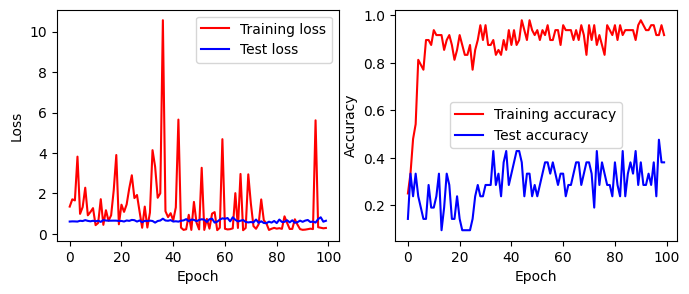

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Generate synthetic dataset
n_features = 7070
n_classes = 5
X, y = make_classification(n_samples=69, n_features=n_features, 
                           n_informative=10, n_classes=n_classes, 
                           weights=[39/69, 7/69, 7/69, 10/69, 6/69], random_state=42)

# Step 2: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    stratify=y, random_state=42)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# Define the Expert Network
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
      super().__init__()
      self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return torch.relu(self.fc(x))

# Define the Gating Network
class Router(nn.Module):
    def __init__(self, input_dim, num_experts):
      super().__init__()
      self.fc = nn.Linear(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, num_experts]
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.fc(x)
      if self.training:
        x += torch.randn_like(x) # Add noise to the logits
      return x
    
def topk(router_logits: torch.Tensor, top_k: int, dim: int, expert_capacity: int) -> tuple[torch.Tensor, torch.Tensor]:
  batch_size = router_logits.size(0)
  num_experts = router_logits.size(1)
  topk_logits, topk_indices = torch.topk(router_logits, top_k, dim=dim) # [batch_size, top_k]
  
  sorted_indices = torch.argsort(router_logits, dim=dim, descending=True)
  new_logits, new_indices = topk_logits.clone(), topk_indices.clone()

  expert_assigned = torch.zeros(num_experts)
  for i in range(batch_size):
    if (expert_assigned == expert_capacity).sum() == 4:
      break

    for j in range(top_k):
      expert_index = sorted_indices[i, j]
      if expert_assigned[expert_index] < expert_capacity:
        expert_assigned[expert_index] += 1
        continue

      for next_expert_index in sorted_indices[i, j:]:
        if expert_assigned[next_expert_index] == expert_capacity:
          continue

        if next_expert_index in new_indices[i]: # prevent duplicate
          continue

        new_logits[i, j] = router_logits[i, next_expert_index]
        new_indices[i, j] = next_expert_index
        expert_assigned[next_expert_index] += 1
        break

  return new_logits, new_indices

# Define the MoE Model
class MoE(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, num_experts: int, top_k: int):
      super().__init__()
      self.output_dim = output_dim
      self.num_experts = num_experts
      self.top_k = top_k
      
      # Create the experts
      self.experts = nn.ModuleList([Expert(input_dim, output_dim) for _ in range(num_experts)])

      # Create the router
      self.router = Router(input_dim, num_experts)
    
    # [batch_size, input_dim] -> [batch_size, output_dim]
    # Note: The gradients are computed 
    # based on how much each expert's output contribution to the loss.
    # If the an expert is used only once for a specific sample,
    # it will receive a gradient based only on that single sample's contribution
    # to the overall loss.
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
      # Get router logts
      router_logits: torch.Tensor = self.router(x) # [batch_size, num_experts]

      # Get the top-k expert indices for each sample in the batch
      expert_capacity = int(x.size(0) * self.top_k / self.num_experts)
      # Version 0.5: Expert Capacity "Prevent Overtrained Expert Train"
      # topk_logits, topk_indices = torch.topk(router_logits, self.top_k, dim=-1) # [batch_size, top_k]
      # Version 0.6: Expert Capacity "Naive Let Undertrained Expert Train"
      topk_logits, topk_indices = topk(router_logits, self.top_k, dim=-1, expert_capacity=expert_capacity)

      weighted_outputs = torch.zeros(x.size(0), self.output_dim)
      for i, expert in enumerate(self.experts):
        expert_mask = (topk_indices == i).any(dim=-1) # [top_k]

        # Version 0.5
        # true_indicies = torch.nonzero(expert_mask)
        # if true_indicies.size(0) > expert_capacity:
        #   expert_mask[true_indicies[expert_capacity:]] = False

        if expert_mask.any():
          expert_input = x[expert_mask]
          expert_output = expert(expert_input)

          expert_logits = topk_logits[topk_indices == i]
          # Version 0.5
          # expert_logits = expert_logits[:expert_capacity]
          weighted_output = expert_output * expert_logits.unsqueeze(-1)

          weighted_outputs[expert_mask] += weighted_output

      return weighted_outputs, router_logits

# [batch_size, num_experts] -> [1]
def load_balancing_loss_fn(router_logits: torch.Tensor) -> torch.Tensor:
  """
  If the sum of the router logits is not balanced across the experts,
  the standard deviation of the sum will be high.
  If the sum of the router logits is balanced across the experts,
  the standard deviation of the sum will be low.
  """
  return router_logits.sum(0).std(0)

# Training the MoE model
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, 
               optimizer: torch.optim.Optimizer) -> torch.Tensor:
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size
  avg_loss, avg_accuracy = 0, 0

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    # Compute predictions and loss
    pred, router_logits = model(X)
    loss: torch.Tensor = loss_fn(pred, y) + load_balancing_loss_fn(router_logits) * 1e-4

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    avg_loss += loss.item()
    avg_accuracy += (pred.argmax(1) == y).sum().item()

  # loss, current = loss.item(), batch * batch_size + len(X)
  # print(f"loss: {loss:>7f} [{current:>2d}/{size:>2d}]")

  avg_loss /= batch_size
  avg_accuracy /= size

  return avg_loss, avg_accuracy

# Evaluate the MoE model
def test_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> torch.Tensor:
  model.eval()
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size
  avg_loss, avg_accuracy = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred, _ = model(X)
      avg_loss += loss_fn(pred, y).item()
      avg_accuracy += (pred.argmax(1) == y).sum().item()
  
  avg_accuracy /= size
  avg_loss /= batch_size
  # print(f'Test Error: \n Accuracy: {100 * correct:>0.1f}%, Avg loss: {test_loss:>8f} \n')

  return avg_loss, avg_accuracy

# Instantiate the MoE model
model = MoE(input_dim=n_features, output_dim=n_classes, num_experts=3, top_k=1)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for t in range(epochs):
  # print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer) # Train the model
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_loss, test_accuracy = test_loop(val_loader, model, loss_fn) # Evaluate the model on the validation set
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(range(epochs), train_losses, 'r', label='Training loss')
plt.plot(range(epochs), test_losses, 'b', label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(epochs), train_accuracies, 'r', label='Training accuracy')
plt.plot(range(epochs), test_accuracies, 'b', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()